# Logistic Regression Example Notebook
This example shows how to predict if a student passes a test using Logistic Regression.

The goal is to give a basic introduction to classification problems, so many things will be simplified.

Regarding notation, $a$ is a scalar, $\mathbf{a}$ is a vector (column vector), and $\mathbf{A}$ is a matrix.


# Imports

In [1]:
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Array computation
import seaborn as sns  # Plotting 
from sklearn.linear_model import LinearRegression  # Linear Regression model
from IPython.display import display, clear_output  # Plotting

%matplotlib inline
sns.set_theme()
sns.set_style("ticks")

# Create and Process data
We use fake data for this example. The input is the number of hours a student has studied for a test and the target is a binary label indicating if they have passed the test or not.

We want train_xs to be a matrix with shape ($m$, $n + 1$) with the first column being all ones (in our case $m = 12$ and $n = 1$): 
\begin{align}
\mathbf{X} = \begin{bmatrix} x^1_{0} && \ldots && x^1_{n} \\ \vdots && \ddots && \vdots \\ x^m_{0} && \ldots && x^m_{n} \end{bmatrix}
\end{align}

We want train_ys to be a vector with shape ($m$, 1):
\begin{align}
\mathbf{y} = \begin{bmatrix} y^1 \\ \vdots \\ y^m \end{bmatrix}
\end{align}

(0.0, 25.0)

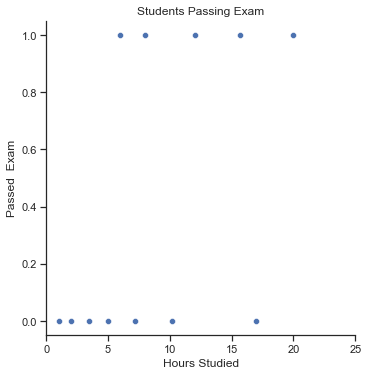

In [2]:
train_xs = np.array([1, 2, 3.5, 5, 6, 7.2, 8, 10.2, 12, 15.7, 17, 20]).reshape(-1, 1)
train_ys = np.array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]).reshape(-1, 1)

# Plot data
sns.relplot(train_xs.flatten(), train_ys.flatten())
plt.title("Students Passing Exam")
plt.ylabel("Passed  Exam")
plt.xlabel("Hours Studied")
plt.xlim([0, 25])


This is a classification problem but for educational purposes let's try fitting a line to this data using sklearn.

(-10.0, 30.0)

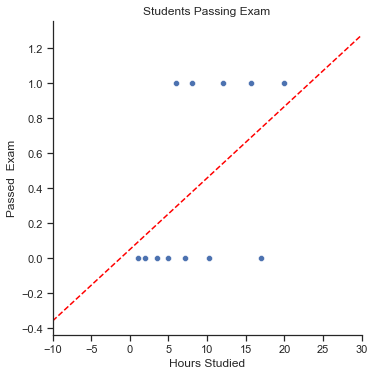

In [3]:
regressor = LinearRegression()
regressor = regressor.fit(train_xs, train_ys)  # Remove the extra features from x

plot_xs = np.linspace(-10, 30, 500)
plot_ys =  regressor.intercept_ + regressor.coef_[0] * plot_xs
sns.relplot(train_xs.flatten(), train_ys.flatten())
sns.lineplot(plot_xs, plot_ys, color="red",linestyle="--")
plt.title("Students Passing Exam")
plt.ylabel("Passed  Exam")
plt.xlabel("Hours Studied")
plt.xlim([-10, 30])

We quickly see that regression can't be directly used for classification in this way. Linear regression produces a line that is not restricted to 0 and 1.

Therefore, we need to define a different hypothesis.

In [4]:
# Add extra feature to xs
ones = np.ones(shape=(12, 1))
train_xs = np.c_[ones, train_xs]  # Shape is now (12, 2)

# Hypothesis Definition
The hypothesis function $h$ is defined as follows for a single example $\mathbf{x}^k$:

\begin{align}
h_\theta(\mathbf{x}^k) & = g(\boldsymbol{\theta}^T\mathbf{x}^k) = \frac{1}{1 + e^{-\boldsymbol{\theta}^T\mathbf{x}^k}}
\end{align}

where $g$ is the logistic or sigmoid function:

\begin{align}
g(z) &= \frac{1}{1 + e^{-z}}
\end{align}

We want to implement a batched method which computes the hypothesis for all examples in one go. To do so, we can implement the following version:

\begin{align}
h_\theta(\mathbf{X}) & =  g(\mathbf{X} \boldsymbol{\theta}) = \begin{bmatrix} h_\theta(\mathbf{x}^1) \\ \vdots \\ h_\theta(\mathbf{x}^m) \end{bmatrix}
\end{align}


In [5]:
def logistic(z):
    return 1/(1 + np.e**-z)

def hypothesis(thetas, input_data):
    return logistic(np.dot(input_data, thetas))

<AxesSubplot:>

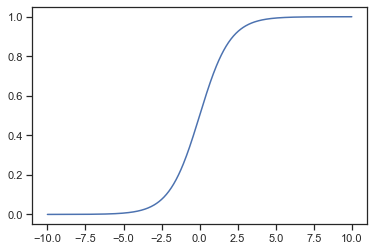

In [6]:
# Plot logistic function
x_plot = np.linspace(-10, 10, 500)
y_plot = logistic(x_plot)

sns.lineplot(x_plot, y_plot)

We use the hypothesis to define the probabilities of the classes:

\begin{align}
P(y^k = 1 | \mathbf{x}^k; \boldsymbol{\theta}) &= h_\theta(\mathbf{x}^k) \\
P(y^k = 0 | \mathbf{x}^k; \boldsymbol{\theta}) &= 1 - h_\theta(\mathbf{x}^k) \\
P(y^k| \mathbf{x}^k; \boldsymbol{\theta}) &= (h_\theta(\mathbf{x}^k))^{y^{k}} (1- h_\theta(\mathbf{x}^k))^{1 - y^{k}}  \\
\end{align}

In [7]:
def class_prob(thetas, input_data, class_n):
    hypothesis_estimate = hypothesis(thetas, input_data)
    return (hypothesis_estimate ** class_n) * (1-hypothesis_estimate)**(1-class_n)

# Learning Algorithm

## Cost Function
We want to maximise the likelihood of our training data:
\begin{align}
L(\boldsymbol\theta) &= P(\mathbf{y}| \mathbf{X}; \boldsymbol{\theta}) \\
                     &= \prod_{k=1}^m P(y^k| \mathbf{x}^k; \boldsymbol{\theta})
\end{align}

To make things easier, we will instead minimise the negative log likelihood:
\begin{align}
l(\boldsymbol\theta) &= -log(L(\boldsymbol\theta)) \\
                     &= -\left[\sum_{k=1}^m y^klog(h_\theta(\mathbf{x}^k)) + (1 - y^k)log(1 - h_\theta(\mathbf{x}^k))\right]
\end{align}

We can instead implement a vectorized form which returns the negative log likelihood per example:
\begin{align}
l(\boldsymbol\theta) &= -\left[\mathbf{y} * log(h_\theta(\mathbf{X})) + (\mathbf{1} - \mathbf{y}) * log(\mathbf{1} - h_\theta(\mathbf{X}))\right]
\end{align}

In [8]:
def cost_function(thetas, input_data, target_data):
    hypothesis_result = hypothesis(thetas, input_data)
    return -(target_data * np.log(hypothesis_result) + (1 - target_data) * np.log(1 - hypothesis_result))

## Gradient Descent
Second step, define gradient descent per epoch, where each parameter $\theta_i$ is updated following:
\begin{align}
\theta_i & ≔ \theta_i - \alpha \frac{\partial}{\partial \theta_i} l(\boldsymbol\theta) \\
& ≔ \theta_i - \alpha \sum_{k=1}^m (h_\theta(\mathbf{x}^k) - y^k)x^k_i
\end{align}
As before, we can instead implement a vectorized operation:

\begin{align}
\boldsymbol{\theta} & ≔ \boldsymbol{\theta} - \alpha \mathbf{X}^T(h_\theta(\mathbf{X}) - \mathbf{y})
\end{align}

In [9]:
def gradient_descent(thetas, input_data, target_data, alpha=0.1):
    """
    thetas: parameters for the hypothesis, expected shape is (2, 1)
    input_data: full matrix of input data, expected shape is (n_samples, 2)
    target_data: full vector of target data, expected shape is (n_samples, 1)
    alpha: learning rate, defaults to 0.1

    return: New parameters, shape is (2, 1)
    """
    return thetas - alpha * np.dot(input_data.T, hypothesis(thetas, input_data) - target_data)

# Train


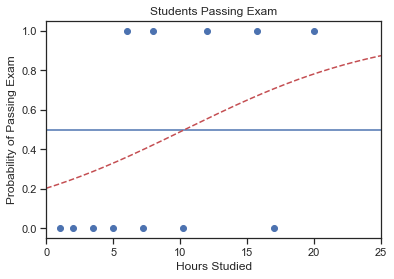

In [10]:
parameters = np.array([[0.01], [0.01]])

# Create array of xs to use for plotting 
x_space = np.linspace(0, 25, 500).reshape(500, 1)
ones = np.ones(shape=(500, 1))
x_added = np.c_[ones, x_space]

def create_fig():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 

    return fig, ax

def plot(ax, fig, parameters):
    current_curve = hypothesis(parameters, x_added)
    
    ax.cla()
    
    ax.set_xlim([0, 25])
    ax.set_ylim([-0.05, 1.05])
    ax.plot(x_space.flatten(), current_curve.flatten(), "r--")
    ax.scatter(train_xs[:, 1], train_ys.flatten())
    ax.hlines(0.5, 0, 25)
    ax.set_title("Students Passing Exam")
    ax.set_ylabel("Probability of Passing Exam")
    ax.set_xlabel("Hours Studied")
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.0001)

def train(parameters, n_epochs=300):
    # Create empty figure for plotting
    fig, ax = create_fig()
    
    # Iterate over n_epochs
    for epoch in range(n_epochs):        
        parameters = gradient_descent(parameters, train_xs, train_ys, alpha=0.005)
        plot(ax, fig, parameters)
    
    return parameters

trained_parameters = train(parameters)

In [11]:
# Compute accuracy for the training set
def class_accuracy(thetas, input_data, targets):
    probs = class_prob(thetas, input_data, targets)
    correct = (probs >= 0.5).sum()  # Using >= means that we say passing when the probability is 50%
    return correct/probs.size

print(f"Final training accuracy: {class_accuracy(trained_parameters, train_xs, train_ys):.2f}")

Final training accuracy: 0.75


## Library Version

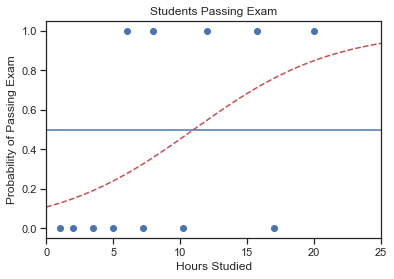

In [12]:
import sklearn.linear_model

lr_classifier = sklearn.linear_model.LogisticRegression()
lr_classifier.fit(train_xs[:, 1:], train_ys)

sklearn_params = np.array([lr_classifier.intercept_[0], lr_classifier.coef_[0, 0]])  # Write the learned parameters as before
fig, ax = create_fig()
plot(ax, fig, sklearn_params)

In [13]:
lr_acc = lr_classifier.score(train_xs[:, 1:], train_ys)
lr_acc

0.75